In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import scipy
import statsmodels.api as sm

In [2]:
def getData(path):
    df = pd.read_csv(path, sep=',', header=0, index_col=0)
    return df

names = pickle.load(open('../../data/hosts/common_names.p', 'rb')) # Convert between common and scientific names
names['Chimp_pts'] = 'Pan_troglodytes_schweinfurthii'

bmr = getData('../../data/determinants/body_mass_rawdata.csv') # body mass values
hgd = getData('../../data/determinants/hostdistance_rawdata.csv') # host genetic distance
hgd_names = { i: i.split('|')[2] for i in list(hgd.columns.values)+list(hgd.index.values) } # fix taxa -> host names
hgd.rename(columns=hgd_names, index=hgd_names, inplace=True)
hgd.rename(index={'P._t._schweinfurthii': 'Pan_troglodytes_schweinfurthii'}, 
           columns = {'P._t._schweinfurthii': 'Pan_troglodytes_schweinfurthii'},
          inplace=True)

bf = getData('../../beast/main/discreteTraits/results/discreteTraits_2016-10-25_bf.csv') # Bayes factors

In [3]:
data = [] # Make tidy data
for from_host in bmr.index.values[1:]:
    for to_host in bmr.index.values[1:]:
        if from_host != to_host:
            transmission = 1 if bf.at[names[from_host], names[to_host]] >= 36.0 else 0 # Code transmission as binary variable
            bmr_val = np.log( bmr.at[from_host, 'mass'] / bmr.at[to_host, 'mass'])
            hgd_val = hgd.at[from_host, to_host]
            data.append({ 'log_bmr': bmr_val, 'hgd': hgd_val, 'transmission': transmission, 'intercept': 1 } )
            
data = pd.DataFrame(data, columns=['transmission', 'intercept', 'log_bmr', 'hgd'])

In [4]:
def make_quantiles(df, column):
    df['%s_quantiles'%column] = pd.qcut(df[column], 5, labels=range(5)) # Cut the data into quantiles (makes new categorical series column)
    means = [ df.loc[df['%s_quantiles'%column] == q][column].mean() for q in range(5) ] # Find the mean of each quantile
    df['%s_quantiles'%column].cat.rename_categories(means, inplace=True) # Label each sample with the mean of the quantile it belongs to
    df.sort_values('%s_quantiles'%column, inplace=True)
    
make_quantiles(data, 'log_bmr')
make_quantiles(data, 'hgd')

print pd.value_counts(data['log_bmr_quantiles']) # Sanity check
print data['log_bmr'].min(), data['log_bmr'].max()
print pd.value_counts(data['hgd_quantiles'])
print data['hgd'].min(), data['hgd'].max()

 0.638893    102
-2.224703    102
 0.002860    101
-0.625258    101
 2.246148    100
Name: log_bmr_quantiles, dtype: int64
-3.98444702084 3.98444702084
0.571090    102
0.212457    102
0.134512    102
0.669556    100
0.342258    100
Name: hgd_quantiles, dtype: int64
0.0073 0.6919


In [5]:
bmr_logit = sm.Logit(data['transmission'], data[['log_bmr', 'intercept']]).fit() # Logistic regression summary
hgd_logit = sm.Logit(data['transmission'], data[['hgd', 'intercept']]).fit()
print bmr_logit.summary()
print hgd_logit.summary()

Optimization terminated successfully.
         Current function value: 0.202398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184935
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           transmission   No. Observations:                  506
Model:                          Logit   Df Residuals:                      504
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Jan 2017   Pseudo R-squ.:               0.0008416
Time:                        09:18:29   Log-Likelihood:                -102.41
converged:                       True   LL-Null:                       -102.50
                                        LLR p-value:                    0.6779
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
log_bm

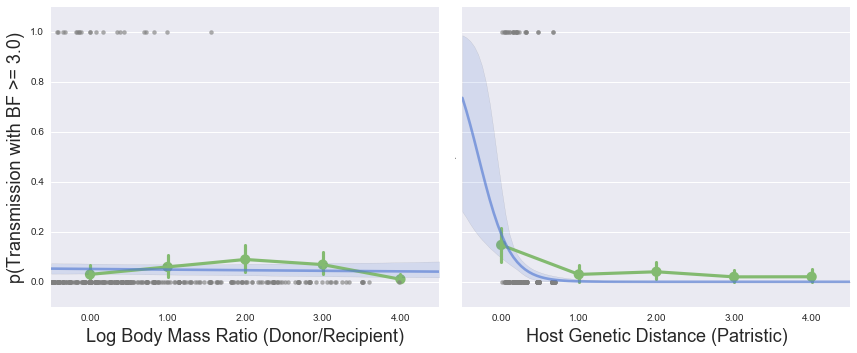

In [6]:
fig, (bmr_ax, hgd_ax) = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=True, facecolor='w') # Note shared Y axis

sns.pointplot(x=data['log_bmr_quantiles'], y=data['transmission'], ax=bmr_ax, color='#83BA70') # Add quantile means
sns.pointplot(x=data['hgd_quantiles'], y=data['transmission'], ax=hgd_ax, color='#83BA70')

sns.regplot(data['log_bmr'], data['transmission'], ax=bmr_ax, 
                        line_kws = {'color':'#547BD3', 'alpha': 0.65, 'zorder': 10}, 
                        scatter_kws={'color': 'gray', 'alpha': 0.65, 'zorder': 10}, logistic=True) # Standard logistic regression plots, includes raw values
sns.regplot(data['hgd'], data['transmission'], ax=hgd_ax,
                        line_kws = {'color':'#547BD3', 'alpha': 0.65, 'zorder': 10}, 
                        scatter_kws={'color': 'gray', 'alpha': 0.65, 'zorder': 10}, logistic=True)

hgd_ax.set_xlabel('Host Genetic Distance (Patristic)', size=18) # Label
bmr_ax.set_ylabel('p(Transmission with BF >= 3.0)', size=18)
bmr_ax.set_xlabel('Log Body Mass Ratio (Donor/Recipient)', size=18)
hgd_ax.set_ylabel(None, size=0)

hgd_ax.set_ylim(-0.1, 1.1) # Format axes
bmr_ax.set_ylim(-0.1, 1.1)

from matplotlib.ticker import FormatStrFormatter
hgd_ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
bmr_ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

sns.set_style('white')
plt.tight_layout()
# plt.savefig('Fig4_Predictors.png', bbox_inches='tight', dpi=300)


### Figure 4: Cross-species transmission is driven by exposure and constrained by host genetic distance.  
For each pair of host species, we **(A)** calculated the log ratio of their average body masses and **(B)** found the patristic genetic distance between them (from a maximum-likelihood tree of mtDNA). To investigate the association of these predictors with cross-species transmission, we treated transmission as a binary variable: 0 if the Bayes factor for the transmission (as inferred by the discrete traits model) was < 3.0, and 1 for a Bayes factor >= 3.0. Each plot shows raw predictor data in gray; the quantiles of the predictor data in green; and the logistic regression and 95% CI in blue. The logistic regression and 95% CI are shown in black.